Episode 1/500, Total Reward: -8334.0
Episode 2/500, Total Reward: -5210.0
Episode 3/500, Total Reward: -5123.0
Episode 4/500, Total Reward: -4746.0
Episode 5/500, Total Reward: -4449.0
Episode 6/500, Total Reward: -3956.0
Episode 7/500, Total Reward: -5644.0
Episode 8/500, Total Reward: -4933.0
Episode 9/500, Total Reward: -3842.0
Episode 10/500, Total Reward: -4466.0
Episode 11/500, Total Reward: -3855.0
Episode 12/500, Total Reward: -4195.0
Episode 13/500, Total Reward: -4247.0
Episode 14/500, Total Reward: -4720.0
Episode 15/500, Total Reward: -3598.0
Episode 16/500, Total Reward: -4317.0
Episode 17/500, Total Reward: -5357.0
Episode 18/500, Total Reward: -4499.0
Episode 19/500, Total Reward: -3161.0
Episode 20/500, Total Reward: -3620.0
Episode 21/500, Total Reward: -3645.0
Episode 22/500, Total Reward: -5311.0
Episode 23/500, Total Reward: -3457.0
Episode 24/500, Total Reward: -3699.0
Episode 25/500, Total Reward: -3806.0
Episode 26/500, Total Reward: -3353.0
Episode 27/500, Total

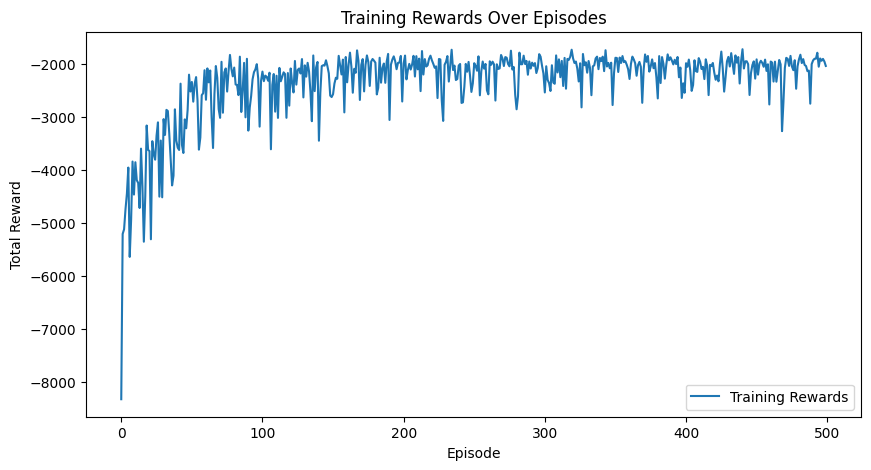

Testing Optimal Policy...
Test Episode 1, Total Reward: -1676.0
Test Episode 2, Total Reward: -1720.0
Test Episode 3, Total Reward: -1669.0
Test Episode 4, Total Reward: -1784.0
Test Episode 5, Total Reward: -1759.0
Test Episode 6, Total Reward: -1757.0
Test Episode 7, Total Reward: -1643.0
Test Episode 8, Total Reward: -1793.0
Test Episode 9, Total Reward: -1738.0
Test Episode 10, Total Reward: -1835.0
Average Test Reward: -1737.4

Simulating random policy...
Episode 1, Total Reward: -1420.0
Episode 2, Total Reward: -1648.0
Episode 3, Total Reward: -1276.0
Episode 4, Total Reward: -1579.0
Episode 5, Total Reward: -1562.0

Simulating greedy policy...
Episode 1, Total Reward: -473.0
Episode 2, Total Reward: -410.0
Episode 3, Total Reward: -399.0
Episode 4, Total Reward: -403.0
Episode 5, Total Reward: -411.0


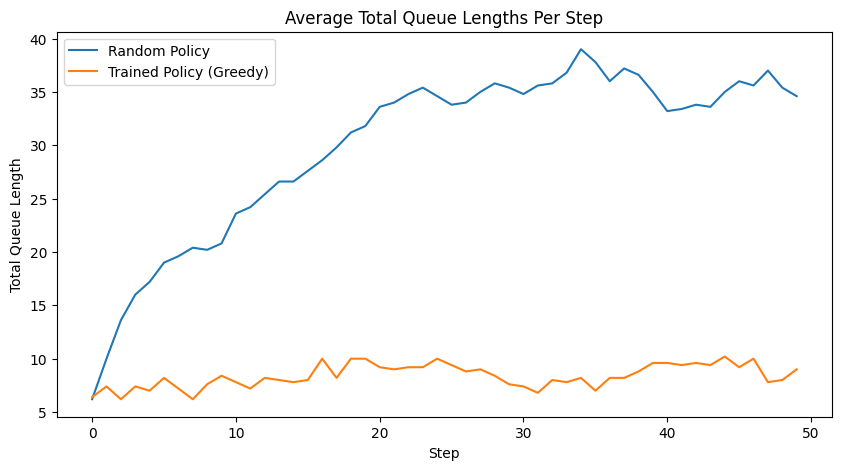

In [ ]:
import numpy as np
import random
import gym
from gym import spaces
import matplotlib.pyplot as plt

# Epsilon-Greedy function
def epsilon_greedy(values, epsilon, seed=None):
    if seed is not None:
        np.random.seed(seed)
    if np.random.rand() < epsilon:
        return np.random.choice(len(values))  # Random action
    else:
        return np.argmax(values)  # Greedy action

# Gym Environment for Traffic
class TrafficEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, num_intersections=4, max_queue=20, seed=None):
        super(TrafficEnv, self).__init__()
        self.num_intersections = num_intersections
        self.max_queue = max_queue

        # Observation: queue sizes [N-S, E-W] for each intersection
        # Each queue size is discrete from 0 to max_queue-1
        # We'll represent the state as a (num_intersections, 2) array.
        self.observation_space = spaces.Box(
            low=0,
            high=self.max_queue - 1,
            shape=(self.num_intersections, 2),
            dtype=np.int32
        )

        # Action: For each intersection, choose between 2 actions: (N-S green or E-W green)
        # This can be represented as MultiDiscrete with [2]*num_intersections
        self.action_space = spaces.MultiDiscrete([2]*self.num_intersections)

        self.state = None
        self.seed_val = seed
        self.seed(seed)

    def seed(self, seed=None):
        self.seed_val = seed
        np.random.seed(seed)
        random.seed(seed)

    def reset(self):
        # Reset the state: initial queue sizes are zeros
        self.state = np.zeros((self.num_intersections, 2), dtype=int)
        return self.state

    def step(self, actions):
        # actions: array-like of length num_intersections, each in {0,1}
        # 0: Green N-S, Red E-W
        # 1: Green E-W, Red N-S

        # Initialize rewards and next_state
        rewards = np.zeros(self.num_intersections)
        next_state = self.state.copy()

        for i in range(self.num_intersections):
            if actions[i] == 0:
                # Green for N-S
                # N-S queue decreases
                next_state[i, 0] = max(0, self.state[i, 0] - random.randint(1, 3))
                # E-W queue increases (red)
                next_state[i, 1] = min(self.max_queue - 1, self.state[i, 1] + random.randint(1, 2))
            else:
                # Green for E-W
                # E-W queue decreases
                next_state[i, 1] = max(0, self.state[i, 1] - random.randint(1, 3))
                # N-S queue increases (red)
                next_state[i, 0] = min(self.max_queue - 1, self.state[i, 0] + random.randint(1, 2))

            # Reward: negative of total queue size
            rewards[i] = -np.sum(next_state[i])

        self.state = np.clip(next_state, 0, self.max_queue - 1)

        # For this simple example, we don't have a done condition
        done = False
        info = {}
        return self.state, rewards, done, info

    def render(self, mode='human'):
        print("Current State:")
        print(self.state)

# ======= Q-Learning Parameters and Setup =======
num_intersections = 4  # number of intersections
max_queue = 20
env = TrafficEnv(num_intersections=num_intersections, max_queue=max_queue)

num_episodes = 500
max_steps_per_episode = 200
gamma = 0.9
lr = 0.1
epsilon = 0.1

# Q-table: shape = (num_intersections, max_queue, max_queue, 2)
Q = np.zeros((num_intersections, max_queue, max_queue, 2))
total_rewards = []

# Training Loop
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    for step in range(max_steps_per_episode):
        # Select actions for each intersection using epsilon-greedy
        actions = [
            epsilon_greedy(Q[i, state[i, 0], state[i, 1], :], epsilon)
            for i in range(num_intersections)
        ]

        next_state, rewards, done, _ = env.step(actions)

        # Update Q-values
        for i in range(num_intersections):
            current_q = Q[i, state[i, 0], state[i, 1], actions[i]]
            max_next_q = np.max(Q[i, next_state[i, 0], next_state[i, 1], :])
            Q[i, state[i, 0], state[i, 1], actions[i]] = current_q + lr * (
                rewards[i] + gamma * max_next_q - current_q
            )

        state = next_state
        total_reward += np.sum(rewards)

        if done:
            break

    total_rewards.append(total_reward)
    print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward}")

print("Training Complete.")

# Plot Training Rewards
plt.figure(figsize=(10, 5))
plt.plot(total_rewards, label="Training Rewards")
plt.title("Training Rewards Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()

# Testing Policy
num_test_episodes = 10
total_test_rewards = []
print("Testing Optimal Policy...")

for episode in range(num_test_episodes):
    state = env.reset()
    total_reward = 0

    for step in range(max_steps_per_episode):
        # Greedy actions
        actions = [np.argmax(Q[i, state[i, 0], state[i, 1], :]) for i in range(num_intersections)]
        next_state, rewards, done, _ = env.step(actions)
        total_reward += np.sum(rewards)
        state = next_state
        if done:
            break

    total_test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")

avg_test_reward = np.mean(total_test_rewards)
print(f"Average Test Reward: {avg_test_reward}")

# Simulation to compare random vs trained policy
def simulate_policy(env, Q=None, num_episodes=5, max_steps_per_episode=50, policy_type="random"):
    print(f"\nSimulating {policy_type} policy...")
    all_rewards = []
    all_queues = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        episode_queues = []

        for step in range(max_steps_per_episode):
            if policy_type == "random":
                # Sample once for a vector of actions for all intersections
                actions = env.action_space.sample()
            else:
                # Use the greedy (trained) policy
                actions = [np.argmax(Q[i, state[i, 0], state[i, 1], :]) for i in range(env.num_intersections)]
                actions = np.array(actions)  # Ensure it's a NumPy array if needed

            next_state, rewards, done, _ = env.step(actions)
            total_reward += np.sum(rewards)
            episode_queues.append(np.sum(env.state))
            state = next_state

            if done:
                break

        all_rewards.append(total_reward)
        all_queues.append(episode_queues)
        print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    return all_rewards, all_queues


# Simulate random policy
random_rewards, random_queues = simulate_policy(env, policy_type="random")

# Simulate greedy (trained) policy
greedy_rewards, greedy_queues = simulate_policy(env, Q=Q, policy_type="greedy")

# Plot Comparison
plt.figure(figsize=(10, 5))
plt.plot(np.mean(random_queues, axis=0), label="Random Policy")
plt.plot(np.mean(greedy_queues, axis=0), label="Trained Policy (Greedy)")
plt.title("Average Total Queue Lengths Per Step")
plt.xlabel("Step")
plt.ylabel("Total Queue Length")
plt.legend()
plt.show()




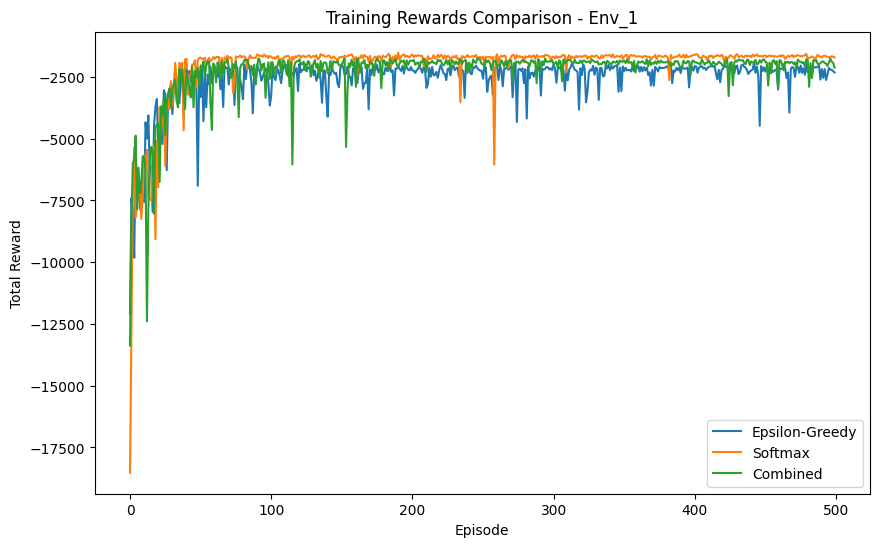

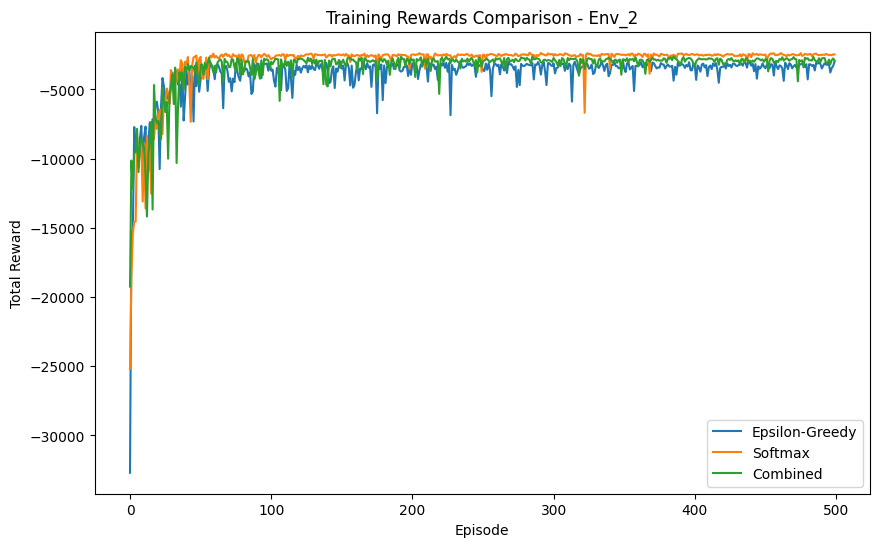

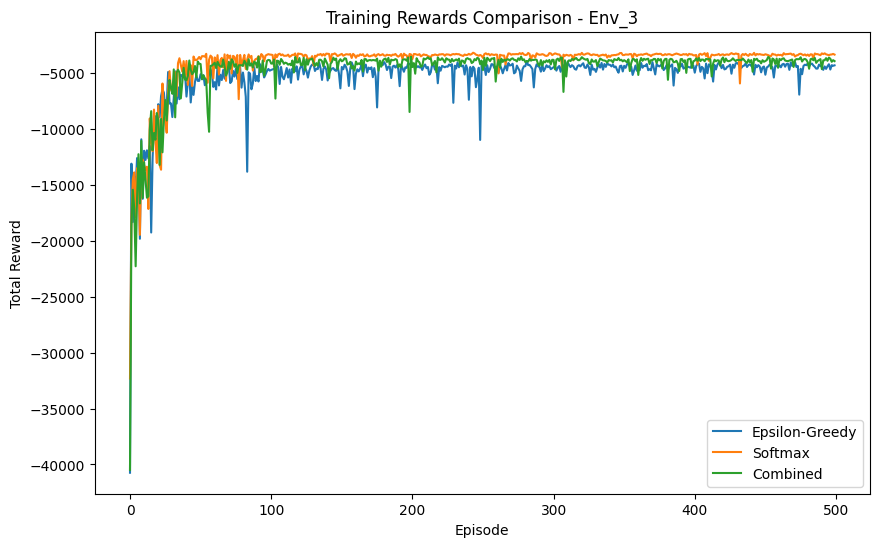

In [ ]:
import numpy as np
import random
import gym
from gym import spaces
import matplotlib.pyplot as plt

# Epsilon-Greedy function
def epsilon_greedy(values, epsilon, seed=None):
    if seed is not None:
        np.random.seed(seed)
    if np.random.rand() < epsilon:
        return np.random.choice(len(values))  # Random action
    else:
        return np.argmax(values)  # Greedy action

# Softmax function for action selection
def softmax(values, temperature):
    exp_values = np.exp(values / temperature)
    probabilities = exp_values / np.sum(exp_values)
    return np.random.choice(len(values), p=probabilities)

# Gym Environment for Traffic
class TrafficEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, num_intersections=4, max_queue=20, seed=None):
        super(TrafficEnv, self).__init__()
        self.num_intersections = num_intersections
        self.max_queue = max_queue
        self.observation_space = spaces.Box(
            low=0, high=self.max_queue - 1, shape=(self.num_intersections, 2), dtype=np.int32
        )
        self.action_space = spaces.MultiDiscrete([3] * self.num_intersections)
        self.state = None
        self.seed(seed)

    def seed(self, seed=None):
        np.random.seed(seed)
        random.seed(seed)

    def reset(self):
        self.state = np.zeros((self.num_intersections, 2), dtype=int)
        return self.state

    def step(self, actions):
        rewards = np.zeros(self.num_intersections)
        next_state = self.state.copy()

        for i in range(self.num_intersections):
            if actions[i] == 0:
                next_state[i, 0] = max(0, self.state[i, 0] - random.randint(2, 4))
                next_state[i, 1] += random.randint(1, 2)
            elif actions[i] == 1:
                next_state[i, 1] = max(0, self.state[i, 1] - random.randint(2, 4))
                next_state[i, 0] += random.randint(1, 2)
            else:
                next_state[i, 0] += random.randint(0, 1)
                next_state[i, 1] += random.randint(0, 1)

            queue_size_penalty = np.sum(next_state[i])
            clear_bonus = 5 if queue_size_penalty == 0 else 0
            rewards[i] = -(queue_size_penalty**1.5) + clear_bonus

        self.state = np.clip(next_state, 0, self.max_queue - 1)
        done = False
        info = {}
        return self.state, rewards, done, info

    def render(self, mode='human'):
        print("Current State:")
        print(self.state)

# Training Function
def train_policy(env, policy_fn, Q_table, num_episodes, max_steps, **kwargs):
    total_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        for step in range(max_steps):
            actions = []
            for i in range(env.num_intersections):
                if policy_fn == epsilon_greedy:
                    actions.append(policy_fn(Q_table[i, int(state[i, 0]), int(state[i, 1]), :], epsilon=kwargs['epsilon']))
                elif policy_fn == softmax:
                    actions.append(policy_fn(Q_table[i, int(state[i, 0]), int(state[i, 1]), :], temperature=kwargs['temperature']))
                else:
                    actions.append(policy_fn(Q_table[i, int(state[i, 0]), int(state[i, 1]), :], epsilon=kwargs['epsilon'], temperature=kwargs['temperature']))
            next_state, rewards, done, _ = env.step(actions)
            for i in range(env.num_intersections):
                current_q = Q_table[i, int(state[i, 0]), int(state[i, 1]), actions[i]]
                max_next_q = np.max(Q_table[i, int(next_state[i, 0]), int(next_state[i, 1]), :])
                Q_table[i, int(state[i, 0]), int(state[i, 1]), actions[i]] = current_q + lr * (
                    rewards[i] + gamma * max_next_q - current_q
                )
            state = next_state
            total_reward += np.sum(rewards)
        total_rewards.append(total_reward)
    return total_rewards

# Q-Learning Parameters
num_episodes = 500
max_steps_per_episode = 200
gamma = 0.9
lr = 0.1
epsilon = 0.2

# Initialize Multiple Environments
envs = [
    TrafficEnv(num_intersections=4, max_queue=20),  # Original environment
    TrafficEnv(num_intersections=6, max_queue=25),  # More intersections, larger queues
    TrafficEnv(num_intersections=8, max_queue=30),  # Even more intersections and queues
]

policies = [epsilon_greedy, softmax, lambda Q, **kwargs: combined_policy(Q, kwargs['epsilon'], kwargs['temperature'])]
policy_names = ["Epsilon-Greedy", "Softmax", "Combined"]

# Combined Policy Definition
def combined_policy(Q_values, epsilon, temperature):
    if np.random.rand() < 0.5:
        return epsilon_greedy(Q_values, epsilon)
    else:
        return softmax(Q_values, temperature)

# Train Policies on Each Environment
results = {}
for idx, env in enumerate(envs):
    results[f"Env_{idx + 1}"] = {}
    for policy_fn, policy_name in zip(policies, policy_names):
        Q_table = np.zeros((env.num_intersections, env.max_queue, env.max_queue, 3))
        rewards = train_policy(env, policy_fn, Q_table, num_episodes, max_steps_per_episode, epsilon=epsilon, temperature=1.0)
        results[f"Env_{idx + 1}"][policy_name] = rewards

# Plot Results
for env_name, env_results in results.items():
    plt.figure(figsize=(10, 6))
    for policy_name, rewards in env_results.items():
        plt.plot(rewards, label=policy_name)
    plt.title(f"Training Rewards Comparison - {env_name}")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.show()

